In [25]:
import gensim
import re
from lxml import etree

from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from gensim.models.word2vec import Word2Vec
import pandas as pd

from selenium import webdriver
from bs4 import BeautifulSoup

from tqdm import tqdm
import operator

import networkx as nx
import matplotlib.pyplot as plt

In [2]:
sw = '지난 배포 금지 기업 회사 최근 위해 통해 기자 기사 일보 본문'
file_path='C:/Users/hyunsoo/study/ds_project/crawler/박채희/crawler/풀무원 바른먹거리.csv'
data = pd.read_csv(file_path, encoding='utf-8',index_col = 0)

In [3]:
options = webdriver.ChromeOptions()
# 창 숨기는 옵션 추가
options.add_argument("headless")



driver = 'C:/chromedriver_win32/chromedriver.exe' 
driver = webdriver.Chrome(executable_path=driver,options=options)  # for Windows
driver.get('https://www.ranks.nl/stopwords/korean')
req = driver.page_source
soup = BeautifulSoup(req, 'html.parser')
a = soup.select('#article178ebefbfb1b165454ec9f168f545239 > div.panel-body > table > tbody > tr')

stopwords = []

for x in a[0].select('td'):
    stopword = re.sub('[^ ㄱ-ㅣ가-힣]+',' ',str(x))
    stopwords.extend(' '.join(stopword.split()).split(' '))
driver.close()

stopwords.extend(sw.split())

In [4]:
def clean_text(text):
    cleaned_text = re.sub('[^ ㄱ-ㅣ가-힣]+',' ',text)
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text

okt = Okt()
def get_nouns(text):
    nouns = okt.nouns(text)
    nouns = [word for word in nouns if not (word in stopwords)]
    nouns = [word for word in nouns if len(word)>1]
    return nouns

In [5]:
data = data.dropna()
data['내용'] = data['내용'].apply(lambda x: clean_text(x))
data

data['명사'] = data['내용'].apply(lambda x: get_nouns(x))
data.head()

,언론사,제목,내용,명사
0,경향신문,‘바른 먹거리’ 풀무원 물류센터에서는 무슨 일이?,지난 일 사회관계망서비스에서는 차밑에 들어가 있는 한 노동자의 사진이 화제를 모았다...,"[회관, 서비스, 차밑, 노동자, 사진, 화제, 먹거리, 식품, 풀무원, 물품, 운..."
1,경향신문,"어린이 ‘바른 먹거리 캠페인’ 신청하세요… 풀무원, 사회공헌 교육 확대",풀무원이 어린이들의 바른 식생활을 위해 년부터 실시해온 바른 먹거리 캠페인 교육을 ...,"[풀무원, 어린이, 식생활, 실시, 먹거리, 캠페인, 교육, 확대, 전문, 식생활,..."
2,경향신문,"풀무원, 어린이 바른 먹거리 현장 체험교육",풀무원 홀딩스는 초등학교 여름방학을 맞아 충북 음성 풀무원 두부공장을 돌아보는 풀무...,"[풀무원, 홀딩스, 초등학교, 여름방학, 충북, 음성, 풀무원, 부공, 풀무원, 피..."
3,경향신문,풀무원 ‘바른 먹을거리 교육’에 어린이 신청 늘어,어린이를 대상으로 한 올바른 먹을거리 교육이 학교와 학부모들로부터 관심을 모으고 있...,"[어린이, 대상, 교육, 학교, 학부모, 관심, 풀무원식품, 사장, 효율, 올해, ..."
4,경향신문,"풀무원, 13년 만에 새 CI 발표... 글로벌 로하스 도약 목표",풀무원 새 풀무원이 년 이후 년 만에 기업이미지를 교체했다 계열사 브랜드도 일원화했...,"[풀무원, 풀무원, 이후, 이미지, 교체, 열사, 브랜드, 일원, 풀무원, 서울, ..."


In [6]:
drop_index_list = [] # 지워버릴 index를 담는 리스트
for i, row in data.iterrows():
    temp_nouns = row['명사']
    if len(temp_nouns) == 0: # 만약 명사리스트가 비어 있다면
        drop_index_list.append(i) # 지울 index 추가
        
data = data.drop(drop_index_list) # 해당 index를 지우기

# index를 지우면 순회시 index 값이 중간중간 비기 때문에 index를 다시 지정
data.index = range(len(data))

In [17]:
def mk_tfidf(data):
    cv = CountVectorizer(max_features=1000, tokenizer=get_nouns)
    tdm = cv.fit_transform(data['내용'])
    dataset = pd.DataFrame(data=tdm.todense(),columns=cv.get_feature_names())
    return dataset

In [10]:
def mk_input(tf_idf):
    column_list = list(tf_idf.columns)
    word_length = len(column_list)

    # 각 단어쌍의 빈도수를 저장할 dictionary 생성
    count_dict = {}

    for doc_number in tqdm(range(len(tf_idf)), desc='단어쌍 만들기 진행중'):
        tmp = tf_idf.loc[doc_number]           # 현재 문서의 단어 출현 빈도 데이터를 가져온다.
        for i, word1 in enumerate(column_list):
            if tmp[word1]:              # 현재 문서에 첫번째 단어가 존재할 경우
                for j in range(i + 1, word_length):
                    if tmp[column_list[j]]:              # 현재 문서에 두번째 단어가 존재할 경우
                        count_dict[column_list[i], column_list[j]] = count_dict.get((column_list[i], column_list[j]), 0) + max(tmp[word1], tmp[column_list[j]])

    # count_list에 word1, word2, frequency 형태로 저장할 것이다.
    count_list = []

    for words in count_dict:
        count_list.append([words[0], words[1], count_dict[words]])

    # 단어쌍 동시 출현 빈도를 DataFrame 형식으로 만든다.
    df = pd.DataFrame(count_list, columns=["word1", "word2", "freq"])
    df = df.sort_values(by=['freq'], ascending=False)
    df = df.reset_index(drop=True)
    return df

In [23]:
def draw(df, keyword, length):
#     keyword = '교육'
#     length = 20
    font_family='NanumSquareRound'
    print(keyword, length)
    dataset = df[df['word1']==keyword]

    G_centrality = nx.Graph()

    # 빈도수가 20000 이상인 단어쌍에 대해서만 edge(간선)을 표현한다.
    for ind in list(dataset.index)[:length]:
        G_centrality.add_edge(dataset['word1'][ind], dataset['word2'][ind], weight=int(dataset['freq'][ind]))

    dgr = nx.degree_centrality(G_centrality)        # 연결 중심성
    btw = nx.betweenness_centrality(G_centrality)   # 매개 중심성
    cls = nx.closeness_centrality(G_centrality)     # 근접 중심성
    egv = nx.eigenvector_centrality(G_centrality)   # 고유벡터 중심성
    pgr = nx.pagerank(G_centrality)                 # 페이지 랭크

    # 정렬
    sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
    sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
    sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
    sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
    sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

    # 단어 네트워크를 그려줄 Graph 선언
    G = nx.Graph()

    # 페이지 랭크에 따라 두 노드 사이의 연관성을 결정한다. (단어쌍의 연관성)
    # 연결 중심성으로 계산한 척도에 따라 노드의 크기가 결정된다. (단어의 등장 빈도수)
    for i in range(len(sorted_pgr)):
        G.add_node(sorted_pgr[i][0], nodesize=sorted_dgr[i][1],color='r')

    for ind in list(dataset.index)[:length]:
        G.add_weighted_edges_from([(dataset['word1'][ind], dataset['word2'][ind], int(dataset['freq'][ind]))])

    # 노드 크기 조정
    sizes = [G.nodes[node]['nodesize'] * 500 for node in G]

    options = {
        'edge_color': '#FFDEA2',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
    }


    plt.figure(figsize=(8,5))
    nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=3.5, iterations=100), **options, font_family=font_family)  # font_family로 폰트 등록
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#555555")
    plt.show()

In [18]:
tf_idf = mk_tfidf(data)

In [20]:
words_freq = mk_input(tf_idf)

단어쌍 만들기 진행중: 100%|██████████████████████████████████████████████████████████| 251/251 [00:30<00:00,  8.14it/s]


음식 20


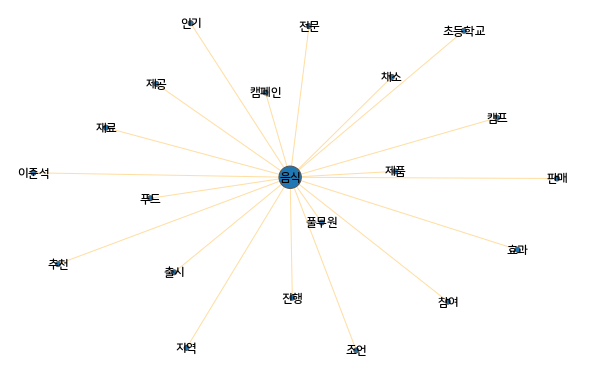

In [26]:
draw(words_freq,'음식',20)

먹거리 20


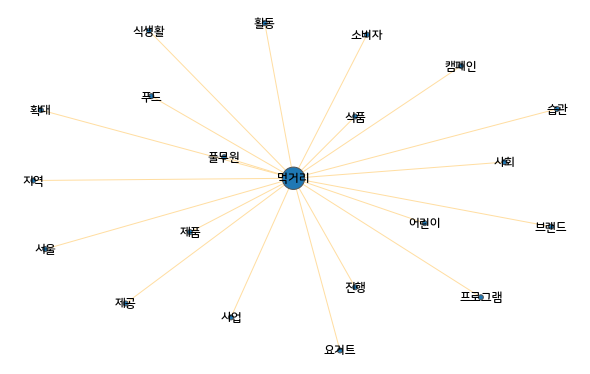

In [29]:
draw(words_freq,'먹거리',20)